In [1]:
# !pip install statsmodels
# !pip install bioinfokit
# !pip install pandas
# !pip install dataframe-image

Setup: Run this cell first!

In [104]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
from bioinfokit.analys import stat
import matplotlib.pyplot as plt
import scipy.stats as stats
import dataframe_image as dfi

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)

ANOVA_MODEL = 'search_interest ~ group'

def perform_one_way_anova(dataframe):
    global ANOVA_MODEL
    model = ols(ANOVA_MODEL,data=dataframe).fit()
    return sm.stats.anova_lm(model, typ=2)

def run_tukey_test(res, dataframe, column_name):
    res.tukey_hsd(df=dataframe, res_var='search_interest', xfac_var=column_name, anova_model=ANOVA_MODEL)
    return res.tukey_summary, res.tukey_hsd(df=dataframe, res_var='search_interest', xfac_var=column_name, anova_model=ANOVA_MODEL)

def make_qq_plot(res, plot_name):
    sm.qqplot(res.anova_std_residuals, line='45')
    plt.title(f'QQ Plot: {plot_name}')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    return plt

def make_qq_hist(res, plot_name):
    plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
    plt.title(f'QQ Histogram: {plot_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    return plt

def test_shapiro_wilk(res):
    w, pvalue = stats.shapiro(res.anova_model_out.resid)
    return {
        'w': w,
        'p-value': pvalue
    }

class NewAnovaAnalysis:
    def __init__(self, df_csv, country, anova_model=ANOVA_MODEL):
        self.res = stat()
        self.dataframe: pd.DataFrame = self.load_and_process_df(df_csv)
        self.dataframe = self.dataframe[self.dataframe.country == country]
        try:
            self.name = self.dataframe.iloc[1].group_language
        except IndexError:
            print('Error: No results found. Cannot run analysis.')
            self.name = 'Unnamed Analysis'
        else:
            self.anova_model = anova_model
            self.country = country

    def load_and_process_df(self, csv_path):
        df = pd.read_csv(csv_path)
        return df[df['group_value'] == True].drop('Unnamed: 0', axis=1).drop('group_value', axis=1)[['title', 'country', 'available', 'original_language', 'group', 'group_language', 'search_interest']]

    def run_analysis(self):
        if self.name != 'Unnamed Analysis':
            print(f'Running Analysis: {self.name} in {self.country}\n\n')
            anova_df = self.perform_one_way_anova()

            print(anova_df)
            dfi.export(anova_df, f'ANOVA_{self.name}_{self.country}.png')
            if anova_df.iloc[0]['PR(>F)'] < .05:
                tukey_test, tukey_obj = self.run_tukey_test('group')
                print(tukey_test)
                dfi.export(tukey_test, f'TUKEY_{self.name}_{self.country}.png')
                shapiro = self.test_shapiro_wilk()
                print(shapiro)
            else:
                print('\nNot significant, skipping tukey test')
        else:
            print('\n\nError loading data; skipping analysis\n\n')

    def perform_one_way_anova(self):
        print(f'One-Way ANOVA: {self.name}')
        return perform_one_way_anova(self.dataframe)

    def make_qq_plot(self):
        return make_qq_plot(self.res, self.name)

    def make_qq_hist(self):
        return make_qq_hist(self.res, self.name)

    def test_shapiro_wilk(self):
        print(f'\n\nShapiro-Wilk Test: {self.name}')
        w, pvalue = stats.shapiro(self.res.anova_model_out.resid)
        return (f'W: {w}; P-Value: {pvalue}')

    def run_tukey_test(self, column_name):
        print(f'\n\nTukey Test: {self.name} [{column_name}]')
        return run_tukey_test(self.res, self.dataframe, column_name)

## Step 1: Initialize Analysis Object

In [20]:
dataframe_file_name = 'claudia_anova_df_9.csv'

my_analysis = NewAnovaAnalysis(dataframe_file_name, 'Hungary')

## Step 2: Run Analysis

In [22]:
my_analysis.run_analysis()

Running Analysis: Hungarian in Hungary


One-Way ANOVA: Hungarian
               sum_sq    df         F    PR(>F)
group      846.163043   2.0  7.232673  0.001264
Residual  4913.653049  84.0       NaN       NaN


[0126/191622.996858:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/191623.093216:INFO:headless_shell.cc(653)] Written to file /tmp/tmp_mi2c1qd/temp.png.




Tukey Test: Hungarian [group]
   group1   group2      Diff     Lower      Upper   q-value   p-value
0  subbed     both  6.392073  2.336436  10.447710  5.318309  0.001000
1  subbed  neither  1.317073 -6.659565   9.293711  0.557161  0.900000
2    both  neither  5.075000 -2.914356  13.064356  2.143459  0.289255


Shapiro-Wilk Test: Hungarian
W: 0.7867830395698547; P-Value: 6.835579879904685e-10


[0126/191623.238205:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/191623.330083:INFO:headless_shell.cc(653)] Written to file /tmp/tmp8mzz7a51/temp.png.


## Step 3: Make Plots

<module 'matplotlib.pyplot' from '/home/wade/anaconda3/envs/chetflix-3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

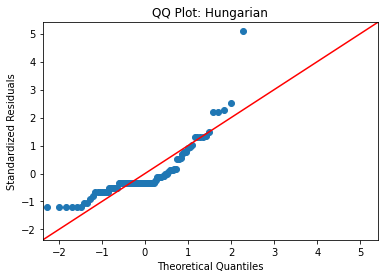

In [23]:
my_analysis.make_qq_plot()

<module 'matplotlib.pyplot' from '/home/wade/anaconda3/envs/chetflix-3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

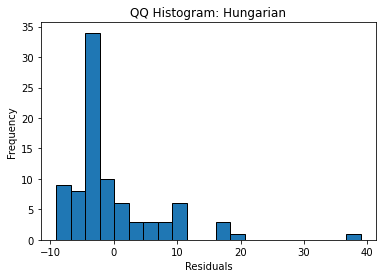

In [24]:
my_analysis.make_qq_hist()

## Step 4: Record Observations

In [37]:
file_list = [f'wade_anova_df_{num}.csv' for num in range(1, 12)]

In [39]:
df_list = [pd.read_csv(file) for file in file_list]

In [27]:
df_list[0]

,Unnamed: 0,title,country,available,original_language,group,group_language,group_value,premiere_date,genre_1,...,Overall.ø.day,Movies.Points,Movies.Days,Movies.ø.day,Kids.Points,Kids.Days,Kids.ø.day,Official.Points,Official.Weeks,search_interest
0,6,7-prisoners,Argentina,True,Brazilian Portuguese,neither,Turkish,True,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
1,21,7-prisoners,Argentina,True,Brazilian Portuguese,both,Turkish,False,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
2,122,7-prisoners,Argentina,True,Brazilian Portuguese,dubbed,Turkish,False,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
3,174,7-prisoners,Argentina,True,Brazilian Portuguese,subbed,Turkish,False,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
4,220,7-prisoners,Australia,False,Brazilian Portuguese,both,Turkish,False,2021-11-05,Dramas,...,0.0,0,0,0.0,0,0,0.0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,596930,zero-to-hero,United Kingdom,False,Cantonese,dubbed,Turkish,False,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,10
13568,596992,zero-to-hero,United States,False,Cantonese,dubbed,Turkish,False,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,7
13569,597019,zero-to-hero,United States,False,Cantonese,subbed,Turkish,False,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,7
13570,597043,zero-to-hero,United States,False,Cantonese,both,Turkish,False,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,7


In [28]:
[print(item.iloc[1].group_language) for item in df_list]

Turkish
Portuguese
Russian
Japanese
Polish
Vietnamese
Hebrew
Telugu
Canadian.French
French
Finnish


[None, None, None, None, None, None, None, None, None, None, None]

In [29]:
print([list(item.country.unique()) for item in df_list])

[['Argentina', 'Australia', 'Belgium', 'Brazil', 'Canada', 'Colombia', 'Czech Republic', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Malaysia', 'Mexico', 'Netherlands', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovakia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom', 'United States'], ['Argentina', 'Australia', 'Belgium', 'Brazil', 'Canada', 'Colombia', 'Czech Republic', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Malaysia', 'Mexico', 'Netherlands', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovakia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom', 'United States'], ['Argentina', 'Australia', 'Belgium', 'Brazil', 'Canada', 'Colo

In [30]:
languages = ['Turkey', 'Portugal', 'Russia', 'Japan', 'Poland', 'Vietnam', 'Israel', 'India', 'Canada', 'France', 'Finland']

In [31]:
file_list

['wade_anova_df_1.csv',
 'wade_anova_df_2.csv',
 'wade_anova_df_3.csv',
 'wade_anova_df_4.csv',
 'wade_anova_df_5.csv',
 'wade_anova_df_6.csv',
 'wade_anova_df_7.csv',
 'wade_anova_df_8.csv',
 'wade_anova_df_9.csv',
 'wade_anova_df_10.csv',
 'wade_anova_df_11.csv']

In [32]:
len(file_list), len(languages)

(11, 11)

In [105]:
analysis_list = [NewAnovaAnalysis(file_list[num], languages[num]) for num in range(len(file_list))]

Error: No results found. Cannot run analysis.
Error: No results found. Cannot run analysis.


In [34]:
analysis_name = [item.name if item.name else 'No Results' for item in analysis_list]

In [35]:
analysis_name

['Turkish',
 'Portuguese',
 'Russian',
 'Japanese',
 'Polish',
 'Unnamed Analysis',
 'Hebrew',
 'Telugu',
 'Canadian.French',
 'French',
 'Unnamed Analysis']

No Results Found: Vietnam, Finland

In [106]:
[item.run_analysis() for item in analysis_list]

Running Analysis: Turkish in Turkey


One-Way ANOVA: Turkish
               sum_sq    df         F    PR(>F)
group       96.314614   2.0  0.583831  0.560005
Residual  6928.742857  84.0       NaN       NaN


[0126/200910.390720:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200910.482693:INFO:headless_shell.cc(653)] Written to file /tmp/tmph_q9qu1v/temp.png.



Not significant, skipping tukey test
Running Analysis: Portuguese in Portugal


One-Way ANOVA: Portuguese
               sum_sq    df         F    PR(>F)
group      177.386847   2.0  3.237081  0.044228
Residual  2301.532694  84.0       NaN       NaN


[0126/200910.602415:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200910.717700:INFO:headless_shell.cc(653)] Written to file /tmp/tmpty22xc7e/temp.png.




Tukey Test: Portuguese [group]
   group1   group2      Diff     Lower      Upper   q-value   p-value
0  subbed     both  3.872068  0.201900   7.542236  3.559983  0.036226
1  subbed  neither  4.023810 -2.070439  10.118058  2.227964  0.262214
2    both  neither  0.151741 -5.170484   5.473966  0.096206  0.900000


[0126/200910.894995:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200910.993045:INFO:headless_shell.cc(653)] Written to file /tmp/tmpon7zuqja/temp.png.




Shapiro-Wilk Test: Portuguese
W: 0.8463014960289001; P-Value: 4.6794454533483076e-08
Running Analysis: Russian in Russia


One-Way ANOVA: Russian
             sum_sq    df         F    PR(>F)
group      0.447958   2.0  0.226802  0.797565
Residual  82.954341  84.0       NaN       NaN


[0126/200911.124510:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200911.257884:INFO:headless_shell.cc(653)] Written to file /tmp/tmp2r6zmpq0/temp.png.



Not significant, skipping tukey test
Running Analysis: Japanese in Japan


One-Way ANOVA: Japanese
            sum_sq    df         F    PR(>F)
group      0.37079   2.0  0.586588  0.558484
Residual  26.54875  84.0       NaN       NaN


[0126/200911.381023:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200911.483296:INFO:headless_shell.cc(653)] Written to file /tmp/tmpcu0h71df/temp.png.



Not significant, skipping tukey test
Running Analysis: Polish in Poland


One-Way ANOVA: Polish
                sum_sq    df         F    PR(>F)
group       123.894380   2.0  0.426977  0.653887
Residual  12187.002172  84.0       NaN       NaN


[0126/200911.598457:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200911.699223:INFO:headless_shell.cc(653)] Written to file /tmp/tmpa7i479z7/temp.png.



Not significant, skipping tukey test


Error loading data; skipping analysis


Running Analysis: Hebrew in Israel


One-Way ANOVA: Hebrew
               sum_sq    df         F    PR(>F)
group       69.565261   2.0  0.642703  0.528435
Residual  4546.020946  84.0       NaN       NaN

Not significant, skipping tukey test
Running Analysis: Telugu in India


One-Way ANOVA: Telugu


[0126/200911.812164:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200911.899546:INFO:headless_shell.cc(653)] Written to file /tmp/tmpucfogclt/temp.png.


                sum_sq    df          F        PR(>F)
group      8035.799505   1.0  43.076717  3.944858e-09
Residual  15856.430380  85.0        NaN           NaN


Tukey Test: Telugu [group]


[0126/200912.015011:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200912.099000:INFO:headless_shell.cc(653)] Written to file /tmp/tmp7qcg986n/temp.png.


    group1  group2       Diff      Lower      Upper   q-value  p-value
0  neither  dubbed  33.259494  23.183933  43.335055  9.281887    0.001


Shapiro-Wilk Test: Telugu
W: 0.7258207201957703; P-Value: 1.884421264863878e-11
Running Analysis: Canadian.French in Canada


One-Way ANOVA: Canadian.French
                sum_sq    df         F    PR(>F)
group      6799.935362   2.0  7.741901  0.000821
Residual  36889.811765  84.0       NaN       NaN


[0126/200912.230491:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200912.316036:INFO:headless_shell.cc(653)] Written to file /tmp/tmphnkmyc8w/temp.png.
[0126/200912.432766:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200912.548841:INFO:headless_shell.cc(653)] Written to file /tmp/tmp66dt0_kc/temp.png.




Tukey Test: Canadian.French [group]
    group1  group2       Diff      Lower       Upper   q-value   p-value
0  neither  subbed  26.047059 -24.248454   76.342571  1.747513  0.437505
1  neither    both  79.047059  28.751546  129.342571  5.303314  0.001000
2   subbed    both  53.000000 -17.713849  123.713849  2.529078  0.179797


[0126/200912.752555:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200912.852632:INFO:headless_shell.cc(653)] Written to file /tmp/tmpbcwq4vm1/temp.png.




Shapiro-Wilk Test: Canadian.French
W: 0.8128857612609863; P-Value: 3.920924918077162e-09
Running Analysis: French in France


One-Way ANOVA: French
               sum_sq    df         F    PR(>F)
group      147.255172   2.0  1.624252  0.203186
Residual  3807.733333  84.0       NaN       NaN

Not significant, skipping tukey test


Error loading data; skipping analysis




[0126/200912.980836:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/200913.094787:INFO:headless_shell.cc(653)] Written to file /tmp/tmpp8u55341/temp.png.


[None, None, None, None, None, None, None, None, None, None, None]

In [41]:
russia_analysis = NewAnovaAnalysis(file_list[2], 'Russia')

In [42]:
russia_analysis.run_analysis()

Running Analysis: Russian in Russia


One-Way ANOVA: Russian
             sum_sq    df         F    PR(>F)
group      0.447958   2.0  0.226802  0.797565
Residual  82.954341  84.0       NaN       NaN

Not significant, skipping tukey test


[0126/192602.466005:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/192602.585108:INFO:headless_shell.cc(653)] Written to file /tmp/tmpambjkioc/temp.png.


In [40]:
df_list[2]

,Unnamed: 0,title,country,available,original_language,group,group_language,group_value,premiere_date,genre_1,...,Overall.ø.day,Movies.Points,Movies.Days,Movies.ø.day,Kids.Points,Kids.Days,Kids.ø.day,Official.Points,Official.Weeks,search_interest
0,17,7-prisoners,Argentina,True,Brazilian Portuguese,both,Russian,False,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
1,38,7-prisoners,Argentina,True,Brazilian Portuguese,dubbed,Russian,False,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
2,76,7-prisoners,Argentina,True,Brazilian Portuguese,neither,Russian,True,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
3,144,7-prisoners,Argentina,True,Brazilian Portuguese,subbed,Russian,False,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
4,186,7-prisoners,Australia,False,Brazilian Portuguese,dubbed,Russian,False,2021-11-05,Dramas,...,0.0,0,0,0.0,0,0,0.0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,596961,zero-to-hero,United Kingdom,False,Cantonese,both,Russian,False,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,10
13568,596999,zero-to-hero,United States,False,Cantonese,neither,Russian,True,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,7
13569,597083,zero-to-hero,United States,False,Cantonese,both,Russian,False,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,7
13570,597104,zero-to-hero,United States,False,Cantonese,dubbed,Russian,False,2021-11-05,Hong Kong,...,0.0,0,0,0.0,0,0,0.0,0,0,7


In [55]:
vietnam_analysis = NewAnovaAnalysis(file_list[5], 'United States')

In [50]:
df_list[5].country.unique()

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Canada',
       'Colombia', 'Czech Republic', 'France', 'Germany', 'Greece',
       'Hong Kong', 'Hungary', 'Iceland', 'India', 'Israel', 'Italy',
       'Japan', 'Lithuania', 'Malaysia', 'Mexico', 'Netherlands',
       'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Singapore', 'Slovakia', 'South Africa', 'South Korea', 'Spain',
       'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine',
       'United Kingdom', 'United States'], dtype=object)

In [56]:
vietnam_analysis.run_analysis()

Running Analysis: Vietnamese in United States


One-Way ANOVA: Vietnamese
                sum_sq    df         F    PR(>F)
group         8.294523   2.0  0.010693  0.989366
Residual  32580.188235  84.0       NaN       NaN

Not significant, skipping tukey test


[0126/192852.924379:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/192853.030751:INFO:headless_shell.cc(653)] Written to file /tmp/tmpvnst9lbt/temp.png.


In [81]:
fin_analysis = NewAnovaAnalysis('wade_anova_df_11.csv', 'Sweden')

In [80]:
df = df_list[-1]
sorted_df = df[df.group_value == True]
sorted_df[sorted_df.available == True]

,Unnamed: 0,title,country,available,original_language,group,group_language,group_value,premiere_date,genre_1,...,Overall.ø.day,Movies.Points,Movies.Days,Movies.ø.day,Kids.Points,Kids.Days,Kids.ø.day,Official.Points,Official.Weeks,search_interest
1,129,7-prisoners,Argentina,True,Brazilian Portuguese,neither,Finnish,True,2021-11-05,Dramas,...,4.7,51,8,6.4,0,0,0.0,10,2,2
9,428,7-prisoners,Belgium,True,Brazilian Portuguese,neither,Finnish,True,2021-11-05,Dramas,...,0.0,12,3,4.0,0,0,0.0,0,0,24
14,630,7-prisoners,Brazil,True,Brazilian Portuguese,neither,Finnish,True,2021-11-05,Dramas,...,7.7,68,8,8.5,0,0,0.0,13,2,1
21,955,7-prisoners,Colombia,True,Brazilian Portuguese,neither,Finnish,True,2021-11-05,Dramas,...,2.5,27,6,4.5,0,0,0.0,0,0,0
31,1378,7-prisoners,France,True,Brazilian Portuguese,neither,Finnish,True,2021-11-05,Dramas,...,0.0,23,6,3.8,0,0,0.0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13415,590303,yara,United States,True,Italian,neither,Finnish,True,2021-10-18,Italian,...,0.0,25,7,3.6,0,0,0.0,0,0,7
13459,592229,zero-to-hero,Hong Kong,True,Cantonese,neither,Finnish,True,2021-11-05,Hong Kong,...,7.1,194,30,6.5,0,0,0.0,32,6,68
13491,593642,zero-to-hero,Malaysia,True,Cantonese,neither,Finnish,True,2021-11-05,Hong Kong,...,0.0,5,3,1.7,0,0,0.0,1,1,52
13523,595013,zero-to-hero,Singapore,True,Cantonese,neither,Finnish,True,2021-11-05,Hong Kong,...,1.0,45,8,5.6,112,13,8.6,7,1,100


In [82]:
fin_analysis.run_analysis()

Running Analysis: Finnish in Sweden


One-Way ANOVA: Finnish
               sum_sq    df         F    PR(>F)
group        8.105389   2.0  0.034314  0.966281
Residual  9920.883117  84.0       NaN       NaN

Not significant, skipping tukey test


[0126/194539.025151:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0126/194539.105971:INFO:headless_shell.cc(653)] Written to file /tmp/tmp8plk74rb/temp.png.


In [67]:
fin_analysis.dataframe.country.unique()

array(['Netherlands'], dtype=object)

In [83]:
import seaborn as sns

In [109]:
sample_analysis = analysis_list[1]

In [110]:
sample_analysis.dataframe

,title,country,available,original_language,group,group_language,search_interest
93,7-prisoners,Portugal,True,Brazilian Portuguese,subbed,Portuguese,12
250,a-classic-horror-story,Portugal,True,Italian,both,Portuguese,16
404,a-perfect-fit,Portugal,True,Indonesian,both,Portuguese,0
561,a-world-without,Portugal,False,Indonesian,both,Portuguese,4
719,afterlife-of-the-party,Portugal,True,English,both,Portuguese,12
...,...,...,...,...,...,...,...
12887,wish-dragon,Portugal,True,English,both,Portuguese,5
13043,worth,Portugal,False,English,neither,Portuguese,6
13197,xtreme,Portugal,True,European Spanish,both,Portuguese,7
13354,yara,Portugal,True,Italian,both,Portuguese,12


In [119]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
comp = pairwise_tukeyhsd(sample_analysis.dataframe, sample_analysis.dataframe['group'])

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [107]:
sample_tukey = analysis_list[1].run_tukey_test('group')



Tukey Test: Portuguese [group]


In [108]:
sample_tukey

(   group1   group2      Diff     Lower      Upper   q-value   p-value
 0  subbed     both  3.872068  0.201900   7.542236  3.559983  0.036226
 1  subbed  neither  4.023810 -2.070439  10.118058  2.227964  0.262214
 2    both  neither  0.151741 -5.170484   5.473966  0.096206  0.900000,
 None)

In [103]:
sample_tukey.plot_simultaneous

AttributeError: 'DataFrame' object has no attribute 'plot_simultaneous'

In [124]:
sns.pointplot(data=sample_tukey[0])

ValueError: min() arg is an empty sequence